# Baseline with Neural Operator Library

In [1]:
import pathlib
import torch
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from neuralop.models import FNO
from neuralop.training import AdamW
from neuralop import LpLoss, H1Loss
from neuralop.training.incremental import IncrementalFNOTrainer
from neuralop.data.transforms.data_processors import IncrementalDataProcessor
from tqdm.notebook import tqdm
from IPython.display import HTML

from acoustic_no.data import AcousticDataset, ShuffledAcousticDataset

In [2]:
# Use the GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load the dataset
dataset = ShuffledAcousticDataset(
    dataset_dir=pathlib.Path("../resources/dataset/processed"),
)
print(f"Dataset size: {len(dataset)}")

Dataset size: 9216


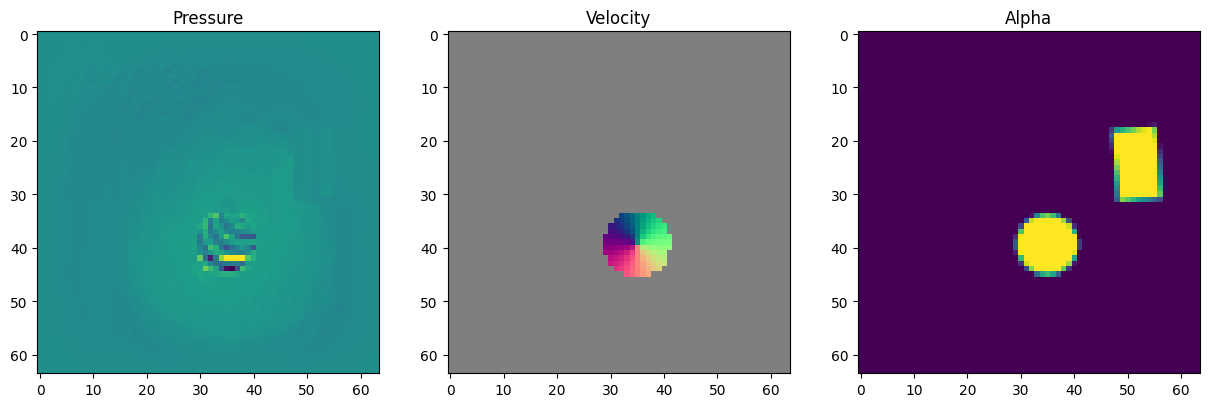

In [4]:
# Display a sample from the dataset
data = dataset[0]
p = data["y"]
v = data["v"]
a = data["a"]
# Move velocity x and y to r and g channels
v = v.reshape(-1, 2, v.shape[1], v.shape[2])
v = v.permute(0, 2, 3, 1)
# Extend the velocity to 3 channels
v = torch.cat([v, torch.zeros_like(v[:, :, :, 0:1])], dim=3)
# Normalize the velocity
v = (v - v.min()) / (v.max() - v.min())
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(p[0, :, :], interpolation="nearest")
ax[0].set_title("Pressure")
ax[1].imshow(v[0, :, :], interpolation="nearest")
ax[1].set_title("Velocity")
ax[2].imshow(a[0, :, :], interpolation="nearest")
ax[2].set_title("Alpha")
plt.show()

In [5]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
val_dataset = Subset(dataset, range(train_size, len(dataset)))
# Use a random subset of the dataset for training
N_TRAIN, N_VAL = 1024, 16
train_dataset = Subset(train_dataset, range(N_TRAIN))
val_dataset = Subset(val_dataset, range(N_VAL))
# Create a data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
)
val_loader = {
    "64x64": torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
    )
}

In [6]:
depth = dataset.depth
depth

64

In [7]:
model = FNO(
    n_modes=(16, 16),
    in_channels=depth * 3 + 1,
    out_channels=depth,
    hidden_channels=64,
    projection_channel_ratio=2,
)
model.to(device)

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(195, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel

In [8]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [9]:
data_transform = IncrementalDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    device=device,
    subsampling_rates=[8, 4, 2, 1],
    dataset_resolution=64,
    dataset_indices=[2, 3],
    epoch_gap=8,
    verbose=True,
)

data_transform = data_transform.to(device)

Original Incre Res: change index to 0
Original Incre Res: change sub to 8
Original Incre Res: change res to 8


In [10]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss = h1loss
eval_losses = {"h1": h1loss, "l2": l2loss}

# Finally pass all of these to the Trainer
trainer = IncrementalFNOTrainer(
    model=model,
    n_epochs=8,
    data_processor=data_transform,
    device=device,
    verbose=True,
    incremental_loss_gap=False,
    incremental_grad=True,
    incremental_grad_eps=0.9999,
    incremental_loss_eps = 0.001,
    incremental_buffer=5,
    incremental_max_iter=1,
    incremental_grad_max_iter=2,
)

trainer.train(
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

Training on 1024 samples
Testing on [16] samples         on resolutions ['64x64'].
Raw outputs of shape torch.Size([32, 64, 8, 8])
[0] time=5.55, avg_loss=55.2044, train_err=1766.5414
Eval: 64x64_h1=51.2890, 64x64_l2=51.6257
[1] time=5.41, avg_loss=49.0560, train_err=1569.7915
Eval: 64x64_h1=47.1027, 64x64_l2=48.2833
[2] time=4.76, avg_loss=43.1841, train_err=1381.8896
Eval: 64x64_h1=46.6033, 64x64_l2=47.2444
[3] time=4.46, avg_loss=39.9143, train_err=1277.2585
Eval: 64x64_h1=46.5494, 64x64_l2=45.8728
[4] time=4.75, avg_loss=37.8176, train_err=1210.1646
Eval: 64x64_h1=45.2991, 64x64_l2=45.0667
[5] time=5.18, avg_loss=36.4101, train_err=1165.1218
Eval: 64x64_h1=44.1457, 64x64_l2=44.1571
[6] time=4.57, avg_loss=34.6507, train_err=1108.8227
Eval: 64x64_h1=44.5923, 64x64_l2=44.5978
[7] time=4.89, avg_loss=32.7647, train_err=1048.4713
Eval: 64x64_h1=43.9006, 64x64_l2=43.9907


{'train_err': 1048.4713172912598,
 'avg_loss': 32.76472866535187,
 'avg_lasso_loss': None,
 'epoch_train_time': 4.8948413749967585,
 '64x64_h1': tensor(43.9006),
 '64x64_l2': tensor(43.9907)}

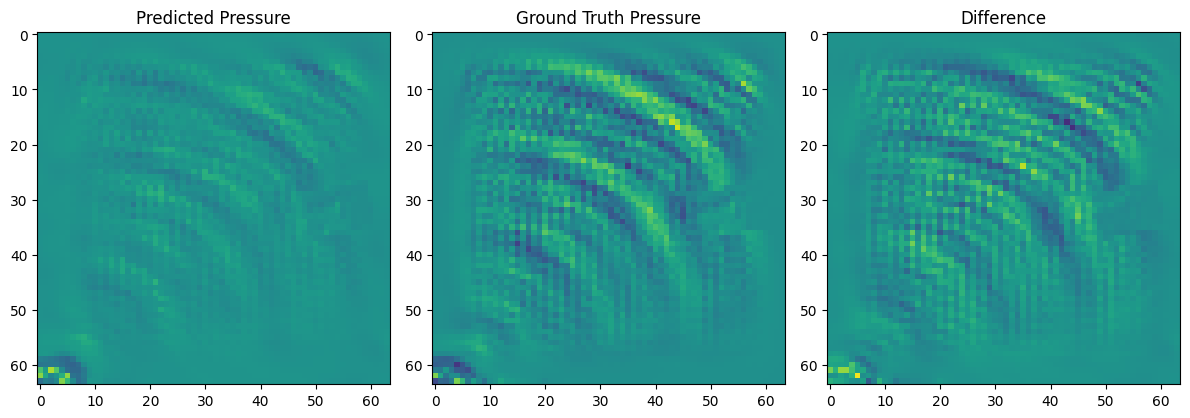

In [11]:
# Inference
model.eval()
eval_data = val_dataset[0]
x = eval_data["x"]
p = eval_data["y"]
v = eval_data["v"]
a = eval_data["a"]
with torch.no_grad():
    pred = model(x.unsqueeze(0).to(device))

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(pred[0, -1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[0].set_title("Predicted Pressure")
ax[1].imshow(p[-1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[1].set_title("Ground Truth Pressure")
ax[2].imshow(pred[0, -1].cpu().numpy() - p[-1].cpu().numpy(), cmap='viridis', vmin=-10, vmax=10)
ax[2].set_title("Difference")
plt.tight_layout()
plt.show()


Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


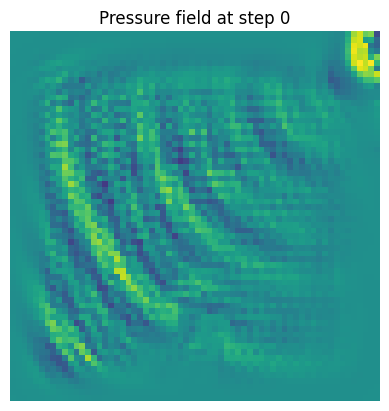

In [12]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=depth, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        p.cpu()[frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == depth - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(depth),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())

Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


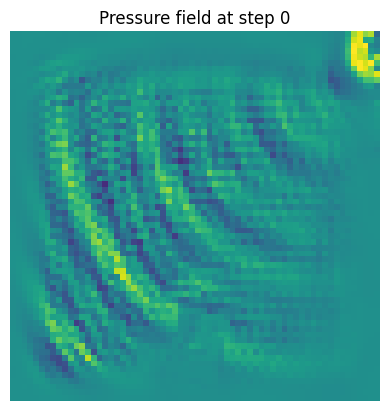

In [13]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=depth, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        pred.cpu()[0, frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == depth - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(depth),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pred_pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())

In [14]:
# Benchmark the model performance on the validation set with MSE loss.
model.eval()
mse_loss = torch.nn.MSELoss()
val_loss = 0.0
with torch.no_grad():
    for data in val_loader["64x64"]:
        x = data["x"].to(device)
        y = data["y"].to(device)
        pred = model(x)
        loss = mse_loss(pred, y)
        val_loss += loss.item()
val_loss /= len(val_loader["64x64"])
print(f"Validation loss: {val_loss:.4f}")

Validation loss: 21.1482
